In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive

C:\Users\tripl\AppData\Local\Temp\ipykernel_16032\102840557.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\tripl\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def model3(obs, ids1, ids2, num_coaches):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [4]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 12

# fake data to see if this model gets same results as previous model
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 469.217427611351
Step 100 : loss = 9.15229606628418
Step 200 : loss = 0.9271459579467773
Step 300 : loss = 9.94105064868927
Step 400 : loss = 4.510937690734863
Step 500 : loss = 6.327960014343262
Step 600 : loss = 1.6398448944091797
Step 700 : loss = 0.7793419361114502
Step 800 : loss = 2.020580291748047
Step 900 : loss = 3.0178754329681396
Step 1000 : loss = 0.5442380905151367
Step 1100 : loss = 6.823520183563232
Step 1200 : loss = 1.5794248580932617
Step 1300 : loss = 6.221094846725464
Step 1400 : loss = 1.9560089111328125
Step 1500 : loss = -0.22755169868469238
Step 1600 : loss = 4.01531982421875
Step 1700 : loss = -1.0733463764190674
Step 1800 : loss = 5.06293249130249
Step 1900 : loss = 0.45827412605285645
Step 2000 : loss = -0.21234750747680664
Step 2100 : loss = 2.131873607635498
Step 2200 : loss = 1.6507339477539062
Step 2300 : loss = -1.5565142631530762
Step 2400 : loss = 2.9544551372528076
Step 2500 : loss = 4.26473069190979
Step 2600 : loss = 2.45992898941040

In [5]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

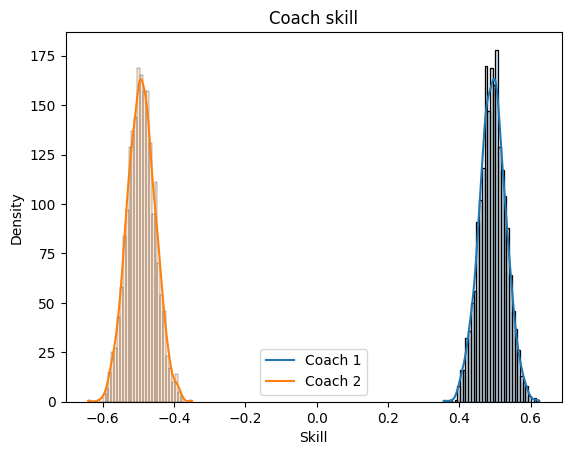

In [6]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")

plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

# Try and make some fake data with multiple players where the player with the higher index always wins.

In [7]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

In [8]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 498.30635690689087
Step 100 : loss = 78.17553949356079
Step 200 : loss = 50.51034080982208
Step 300 : loss = 46.50097477436066
Step 400 : loss = 45.26800751686096
Step 500 : loss = 51.64051687717438
Step 600 : loss = 45.890761375427246
Step 700 : loss = 42.35810887813568
Step 800 : loss = 50.05671465396881
Step 900 : loss = 47.821789264678955
Step 1000 : loss = 57.919772148132324
Step 1100 : loss = 55.026175141334534
Step 1200 : loss = 49.257426619529724
Step 1300 : loss = 52.316818714141846
Step 1400 : loss = 55.22591459751129
Step 1500 : loss = 44.66748356819153
Step 1600 : loss = 44.86872971057892
Step 1700 : loss = 45.171066880226135
Step 1800 : loss = 55.55130362510681
Step 1900 : loss = 45.30184030532837
Step 2000 : loss = 43.87687087059021
Step 2100 : loss = 49.74506664276123
Step 2200 : loss = 48.278974533081055
Step 2300 : loss = 47.748172640800476
Step 2400 : loss = 44.03453230857849
Step 2500 : loss = 50.065279483795166
Step 2600 : loss = 47.564215898513794
S

In [9]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

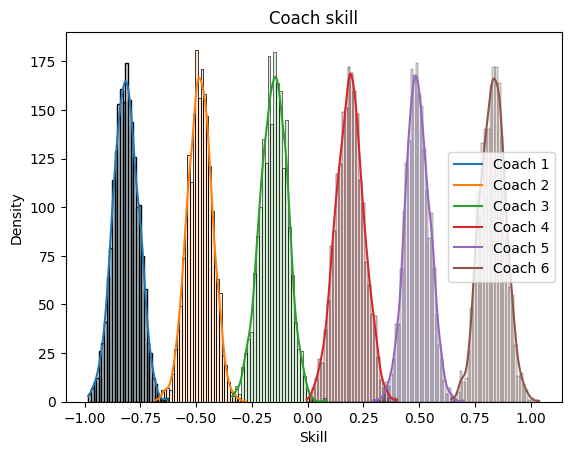

In [10]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


# Try training on real data

In [11]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))
# might fuck up when several coaches has the same number of matches.
sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)
num_games = len(obs)

In [12]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 1935817.9077148438
Step 100 : loss = 507968.9362792969
Step 200 : loss = 473102.7507324219
Step 300 : loss = 460713.1447753906
Step 400 : loss = 457157.3928222656
Step 500 : loss = 456272.8923339844
Step 600 : loss = 455001.0205078125
Step 700 : loss = 455336.62548828125
Step 800 : loss = 455244.5646972656
Step 900 : loss = 454683.85595703125
Step 1000 : loss = 454156.3928222656
Step 1100 : loss = 454362.5017089844
Step 1200 : loss = 454438.2775878906
Step 1300 : loss = 454527.38623046875
Step 1400 : loss = 454407.8566894531
Step 1500 : loss = 454641.8356933594
Step 1600 : loss = 454557.1970214844
Step 1700 : loss = 454582.67626953125
Step 1800 : loss = 454532.18701171875
Step 1900 : loss = 454518.3015136719
Step 2000 : loss = 454301.01708984375
Step 2100 : loss = 454756.65966796875
Step 2200 : loss = 454256.5979003906
Step 2300 : loss = 454556.33447265625
Step 2400 : loss = 454724.4084472656
Step 2500 : loss = 454124.8566894531
Step 2600 : loss = 454693.3728027344
Step

In [13]:
predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

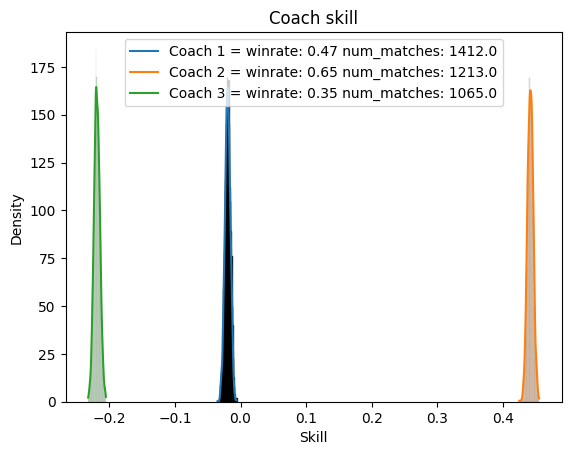

In [14]:
labels = []
for i in range(3):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


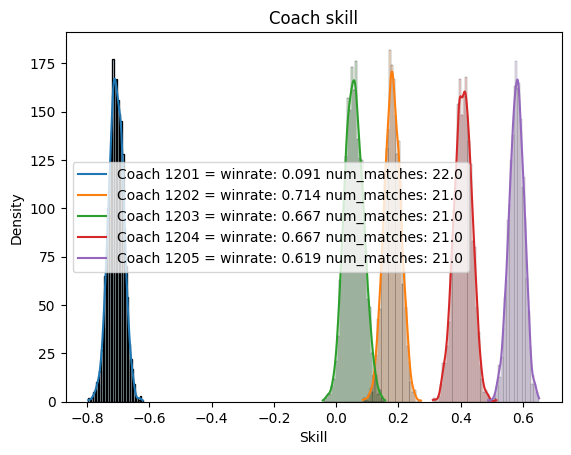

In [24]:
labels = []
for i in range(1200,1205):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.3f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


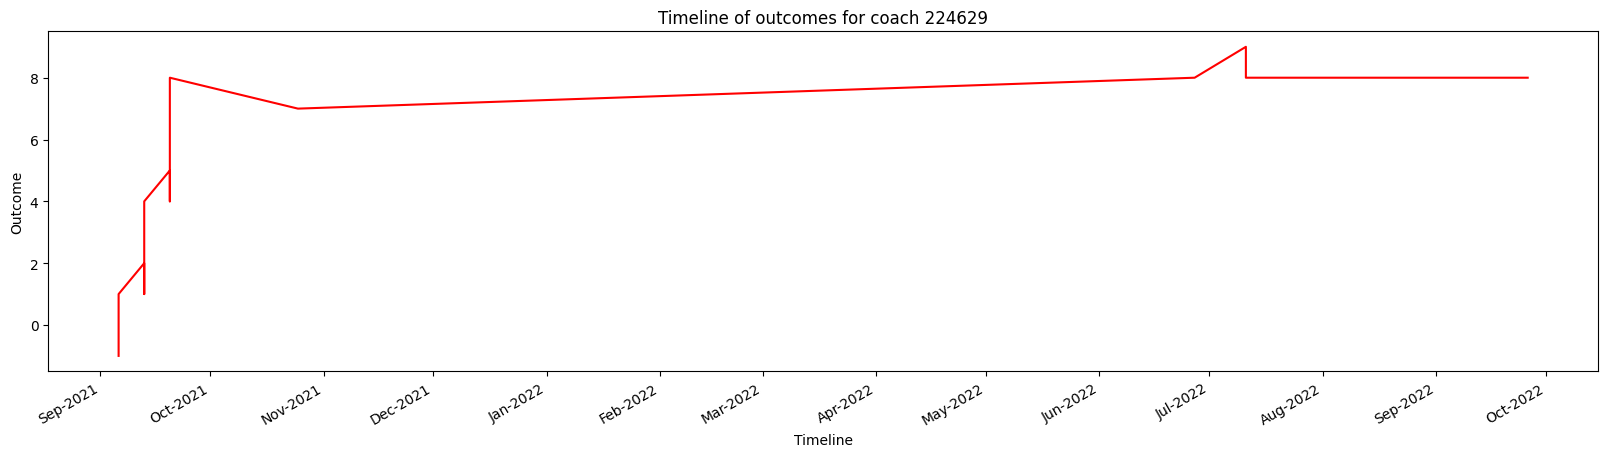

final outcome of sum of results: 8
number of games: 21
winrate: 0.6904761904761905


In [26]:
import matplotlib.dates as mdates

df = pd.read_csv('../data/X_train.csv')

# code for plotting the timeline of a coach
coach_index = 1204
coach_id = sorted_coaches[coach_index]

mask = df['team2_coach_id'] == coach_id

df.loc[mask, 'team2_win'] *= -1
df.loc[mask, 'team1_win'] *= -1

coach1_df = df[df['team1_coach_id'] == coach_id].copy()
coach2_df = df[df['team2_coach_id'] == coach_id].copy()

coach_df = pd.concat([coach1_df, coach2_df])
coach_df['week_date'] = pd.to_datetime(coach_df['week_date'])
coach_df = coach_df.sort_values(by='week_date')

# plot the timeline of outcomes for the given coach
plt.figure(figsize=(20, 5))
cumSumResults = np.cumsum(coach_df['team1_win'])
plt.plot(coach_df['week_date'], cumSumResults, 'r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # 'Month-Year' format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set locator to month
plt.gcf().autofmt_xdate()  # autoformat the x-axis date
plt.xlabel("Timeline")
plt.ylabel("Outcome")
plt.title(f"Timeline of outcomes for coach {coach_id}")
plt.show()

#print last value of sumSumResults
print(f"final outcome of sum of results: {cumSumResults.iloc[-1]}")
# print number of games
print(f"number of games: {len(coach_df)}")
# print winrate


n = len(coach_df)
p = cumSumResults.iloc[-1]
winrate = ((n-p)/2+p)/n
print(f"winrate: {winrate}")


          